# Linear regression of EOF results

***

In [2]:
import numpy as np
import xarray as xr
import pymc3 as pm
from datetime import datetime, timedelta
from matplotlib import pyplot as plt, colors

%matplotlib inline

In [3]:
plt.rcParams['font.size'] = 12

In [4]:
def backaverage(data, w):
    return np.hstack([[data[i-min(i, w+1):i].mean() for i in range(*segment)] for segment in isegments])

# Hardcoded from EOF analysis
isegments = [
    [3169, 6399],
    [11855, 15131],
    [21073, 24176],
    [29329, 32921],
    [37995, 41698],
]

# Load HRDPS
fn = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/HRDPS_1h_20141201_20200201_wind.nc'
with xr.open_dataset(fn) as ds:

    # Meshmask cut everything but open SoG
    landmask = ds.landmask.values
    landmask[:25, :] = 0   # San Juan Islands
    landmask[100:, :] = 0  # Discovery Islands
    landmask[:40, :50] = 0 # Left corner
    landmask[:40, 73:] = 0 # JdF/Gulf Islands
    landmask[40:, 61:] = 0 # Fraser River
    landmask[58:, 53:] = 0 # Howe Sound
    landmask[76:, 35:] = 0 # Jervis Inlet
    landmask = landmask.reshape(-1).astype('bool')

    # Load time, u and v wind components
    time = ds.time.values.astype('datetime64[s]').astype(datetime)
    u, v = [ds[var].values.reshape(-1, len(landmask))[:, landmask] for var in ['u_wind', 'v_wind']]

# Process wind according to Hellerman and Rosenstein 1983, JPO
theta = np.deg2rad(55.5)
wspd = np.sqrt(u**2 + v**2)
v = v * np.cos(theta) - u * np.sin(theta)
C_d = 0.934e-3 + 0.788e-4 * wspd - 0.616e-6 * wspd**2
tau = 1.225 * C_d * v * wspd
HRDPS = {
    'time': time,
    'wspd': v.mean(axis=1),
    'tau': tau.mean(axis=1),
}

In [5]:
def linreg(x, y, samples=1000):

    with pm.Model() as model:
        sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
        intercept = pm.Normal("Intercept", 0, sigma=20)
        x_coeff = pm.Normal("x", 0, sigma=20)
        likelihood = pm.Normal("y", mu=intercept + x_coeff * x, sigma=sigma, observed=y)
        trace = pm.sample(samples, cores=2)

    #x_mean = np.linspace(-0.15, 0.15, 100)
    #y_mean = trace['Intercept'].mean() + trace['x'].mean() * x_mean
    #y = np.vstack([trace[k]['Intercept'] + trace[k]['x'] * x_mean for k in np.random.randint(0, len(trace), samples)])
    #y_01, y_99 = [np.percentile(y, p, axis=0) for p in (1, 99)]
    
    var_y = np.var(trace['Intercept'].mean() + trace['x'].mean() * x)
    r2 = var_y / (var_y + trace['sigma'].mean()**2)
    
    return r2

In [13]:
filepath = '/ocean/bmoorema/research/MEOPAR/SoG_upwelling_EOF_paper/data/'
B = {'nitrate': {}, 'votemper': {}}
for var in ['nitrate', 'votemper']:
    with xr.open_dataset(filepath + f'{var}_EOF.nc') as ds:
        for mode in [0, 2]:
            data = ds.B[:, mode].values
            B[var][mode] = data / np.percentile(abs(data), 99.9)

In [ ]:
r2 = {var: {mode: {func: [] for func in ['greater', 'less']} for mode in [0, 2]} for var in ['nitrate', 'votemper']}

for w in range(10, 151, 10):
    tau = backaverage(HRDPS['tau'], w)
    for var in ['nitrate', 'votemper']:
        for mode in [0, 2]:
            if (var == 'votemper') & (mode == 2):
                break
            for func in ['greater', 'less']:
                index = getattr(np, func)(tau, 0)
                r2[var][mode][func].append(linreg(tau[index], B[var][mode][index]))

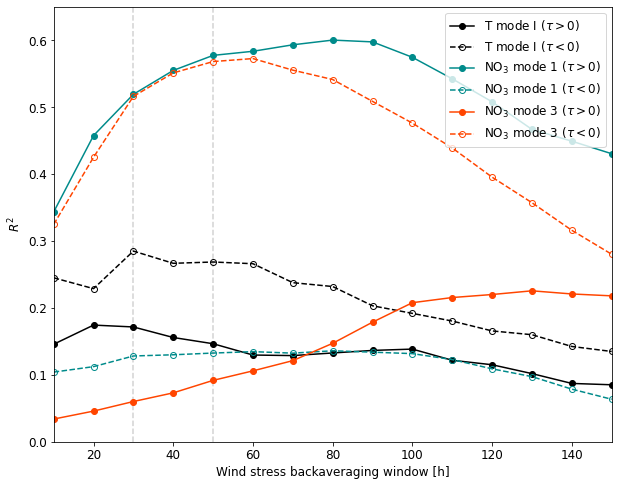

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))
xlim, ylim = [10, 150], [0, 0.65]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('Wind stress backaveraging window [h]')
ax.set_ylabel('$R^2$')
for hour in [30, 50]: ax.plot([hour, hour], ylim, 'k--', color='lightgray')
labels = ['T mode I', 'NO$_3$ mode 1', 'NO$_3$ mode 3']
for var, mode, color, label in zip(['votemper', 'nitrate', 'nitrate'], [0, 0, 2], ['k', 'darkcyan', 'orangered'], labels):
    for func, fs, ls, tag in zip(['greater', 'less'], ['full', 'none'], ['-', '--'], [' ($\\tau > 0$)', ' ($\\tau < 0$)']):
        ax.plot(range(10, 151, 10), r2[var][mode][func], '-o', color=color, fillstyle=fs, ls=ls, label=label + tag)
ax.legend(loc=1)

fig.savefig('/home/bmoorema/Desktop/revision_figs/r2.pdf', bbox_inches='tight')